**Title**: Read DICOM in Memory and Download Zip Member <br>
**Date**:  10/22/2020  
**Description**:  
To illustrate how to get archive Zip File from Flywheel and read DICOM file in memory.


# Requirements
- Have a DICOM Zip Archive stored in at least one Acquisition container.

# Install and Import Dependencies

In [3]:
# Install specific packages required for this notebook
!pip install flywheel-sdk pydicom matplotlib

     |████████████████████████████████| 11.3 MB 17.9 MB/s eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     |████████████████████████████████| 3.1 MB 130.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 42.1 MB/s eta 0:00:01
     |████████████████████████████████| 944 kB 111.0 MB/s eta 0:00:01
You should consider upgrading via the '/home/naterichman/.pyenv/versions/3.8.8/bin/python3.8 -m pip install --upgrade pip' command.


In [4]:
# Import packages
from getpass import getpass
import logging
import os
from pathlib import Path
import time

import flywheel
from permission import check_user_permission
import pydicom
import matplotlib.pyplot as plt


In [5]:
# Instantiate a logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')
log = logging.getLogger('root')

# Flywheel API Key and Client

Get your API_KEY. More on this in the Flywheel SDK doc [here](https://flywheel-io.gitlab.io/product/backend/sdk/branches/master/python/getting_started.html#api-key).

In [6]:
API_KEY = getpass('Enter API_KEY here: ')

Enter API_KEY here: ········


Instantiate the Flywheel API client

In [8]:
fw = flywheel.Client(API_KEY if 'API_KEY' in locals() else os.environ.get('FW_KEY'))

Show Flywheel logging information

In [9]:
log.info('You are now logged in as %s to %s', fw.get_current_user()['email'], fw.get_config()['site']['api_url'])

/home/naterichman/.pyenv/versions/3.8.8/lib/python3.8/site-packages/flywheel/flywheel.py:6300: UserWarning: Client version 15.8.0 does not match server version 16.6.5. Please update your client version!
  warnings.warn('Client version {} does not match server version {}. Please update your client version!'.format(SDK_VERSION, release_version))
2022-07-07 09:48:36,191 WARNING Use "pip install flywheel-sdk~=16.6.4" to install a compatible version for this server
2022-07-07 09:48:36,327 INFO You are now logged in as naterichman@flywheel.io to https://ga.ce.flywheel.io/api


***

# Initialize a few values

Define the Group's ID and Project's Label that contain DICOM zip archive files and let's look for it on your Flywheel instance.

<div class="alert alert-block alert-info" style="color:black"><b>Tip:</b> Group ID and Project Label can be found on top of the Project page on the Flywheel Instance as shown in the snippet below.</div>


![group-id-proj-label](./assets/find-group-id-and-project-label.png)

In [14]:
GROUP_ID = input('Please enter your Group ID here:')

Please enter your Group ID here:nate


In [15]:
PROJECT_LABEL = input('Please enter your Project Label here: ')

Please enter your Project Label here: Q1_Q2_2022


In [16]:
project = fw.lookup(f'{GROUP_ID}/{PROJECT_LABEL}')

***

# Requirements

Before starting off, we want to check your permission on the Flywheel Instance in order to proceed in this notebook. 

In [17]:
min_reqs = {
"site": "user",
"group": "ro",
"project": ['analyses_view_metadata','files_view_metadata','files_view_contents','files_download']
}

`check_user_permission` will return True if both the group and project meet the minimum requirement, else a compatible list will be printed.

In [18]:
check_user_permission(fw, min_reqs, group=GROUP_ID, project=PROJECT_LABEL)

True

***

# Helpful Function

In [22]:
def read_dcm_from_archive(file_entry, acq):
    """
    For a given file entry, read a dicom file from the archive and return a pydicom object.
    Function here will get the second zip member from the Dicom zip archive and stream it to memory as a pydicom.DataSet instance
    """
    import pydicom
    from pydicom.filebase import DicomBytesIO
    
    # Check that this file is valid
    if file_entry['type'] != 'dicom':
        raise TypeError('Must be a DICOM file')
    
    log.info(f'Loading {file_entry["name"]}')
    
    # Using the `get_file_zip_info` method to retrieve the files information within the zip file.
    zip_info = acq.get_file_zip_info(file_entry['name'])
    log.info(f'Reading DICOM file from zip archive')
    if len(zip_info.members) > 1:
        # Read the 2nd member from the path
        raw_dcm = DicomBytesIO(acq.read_file_zip_member(file_entry['name'], zip_info.members[1].path))
    elif len(zip_info.members) > 0:
        # Read the 1st member
        raw_dcm = DicomBytesIO(acq.read_file_zip_member(file_entry['name'], zip_info.members[0].path))
    else:
        return None
    dcm = pydicom.dcmread(raw_dcm, force=True)
    
    return dcm

In [33]:
def show_dcm_info(dcm_list):
    """
    Print out DICOM header and metadata.
    """
    for ds in dcm_list: 
        if ds.SOPClassUID:
            # Normal mode:
            print()
            print(f"SOP Class........: {ds.get('SOPClassUID')} ({ds.SOPClassUID.name})")
            print()

            pat_name = ds.get('PatientName')
            display_name = (pat_name.family_name + ", " + pat_name.given_name) if pat_name else ""
            print(f"Patient's Name...: {display_name}")
            print(f"Patient ID.......: {ds.get('PatientID')}")
            print(f"Modality.........: {ds.get('Modality')}")
            print(f"Study Date.......: {ds.get('StudyDate')}")
            print(f"Image size.......: {ds.get('Rows')} x {ds.get('Columns')}")
            print(f"Pixel Spacing....: {ds.get('PixelSpacing')}")

            # use .get() if not sure the item exists, and want a default value if missing
            print(f"Slice location...: {ds.get('SliceLocation', '(missing)')}")

       
            
            try:
                pixels = ds.pixel_array
            except RuntimeError:
                # Don't have the correct pixel data handler installed
                log.warning(f"Cannot decode image data with TransferSyntax: {ds.get('TransferSyntaxUID')}")
                continue
            print('')
            # plot the image using matplotlib
            # tell matplotlib to display our image, using a gray-scale lookup table.
            plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
            plt.show()
        else:
            print('Invalid DICOM image')
            print('')
            


***

# Main Script

For the first part of the tutorial, we will go through how to read the DICOM file from the zip archive and read the data with `pydicom`. To illustrate we will be reading the 2nd DICOM image in the zip file. 

In [24]:
dcm_list = list()

for sess in project.sessions():
    for acq in sess.acquisitions():
        for files in acq['files']:
            if files['type'] == 'dicom':
                try:
                    dcm = read_dcm_from_archive(files,acq)
                except flywheel.rest.ApiException as e:
                    log.info(f"{files.name} is not a zip, skipping")
                dcm_list.append(dcm)


2022-07-07 09:52:29,451 INFO Loading T1 AX  SE.zip
2022-07-07 09:52:29,601 INFO Reading DICOM file from zip archive
2022-07-07 09:52:30,031 INFO Loading T1_AX_SE.dcm.zip
2022-07-07 09:52:30,183 INFO Reading DICOM file from zip archive
2022-07-07 09:52:30,460 INFO Loading T1 COR SE.zip
2022-07-07 09:52:30,663 INFO Reading DICOM file from zip archive
2022-07-07 09:52:30,885 INFO Loading T1_COR_SE_out.dcm.zip
2022-07-07 09:52:31,159 INFO Reading DICOM file from zip archive
2022-07-07 09:52:31,434 INFO Loading T1 SAG SE.zip
2022-07-07 09:52:31,674 INFO Reading DICOM file from zip archive
2022-07-07 09:52:31,892 INFO Loading T1_SAG_SE_out.dcm.zip
2022-07-07 09:52:32,057 INFO Reading DICOM file from zip archive
2022-07-07 09:52:32,275 INFO Loading dcmout.dcm.zip
2022-07-07 09:52:32,465 INFO Reading DICOM file from zip archive
2022-07-07 09:52:32,656 INFO Loading T1w.dcm.zip
2022-07-07 09:52:32,885 INFO Reading DICOM file from zip archive
2022-07-07 09:52:33,356 INFO Loading 23492_7_1.dicom.z

# View DICOM Image 

Here we will be using `matplotlib` to plot the DICOM Image that we have selected for each Subject and some DICOM information.

2022-07-07 09:58:17,605 WARNING Cannot decode image data with TransferSyntax: None



SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: TCGA-76-6661, 
Patient ID.......: TCGA-76-6661
Modality.........: MR
Study Date.......: 20011208
Image size.......: 320 x 320
Pixel Spacing....: [0.6875, 0.6875]
Slice location...: 97.5

SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: TCGA-76-6661, 
Patient ID.......: nifti_to_dicom
Modality.........: MR
Study Date.......: 20220217
Image size.......: 320 x 320
Pixel Spacing....: [.6875, .6875]
Slice location...: (missing)



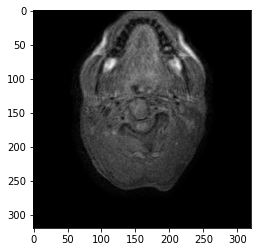

2022-07-07 09:58:17,719 WARNING Cannot decode image data with TransferSyntax: None



SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: TCGA-76-6661, 
Patient ID.......: TCGA-76-6661
Modality.........: MR
Study Date.......: 20011208
Image size.......: 320 x 320
Pixel Spacing....: [0.71875, 0.71875]
Slice location...: 22.5000022388543

SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: TCGA-76-6661, 
Patient ID.......: nifti_to_dicom
Modality.........: MR
Study Date.......: 20220329
Image size.......: 320 x 320
Pixel Spacing....: [.71875, .71875]
Slice location...: (missing)



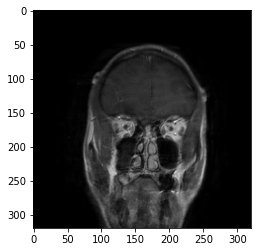

2022-07-07 09:58:17,809 WARNING Cannot decode image data with TransferSyntax: None



SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: TCGA-76-6661, 
Patient ID.......: TCGA-76-6661
Modality.........: MR
Study Date.......: 20011208
Image size.......: 256 x 256
Pixel Spacing....: [0.9375, 0.9375]
Slice location...: 112.499999824927

SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: TCGA-76-6661, 
Patient ID.......: nifti_to_dicom
Modality.........: MR
Study Date.......: 20220329
Image size.......: 256 x 256
Pixel Spacing....: [.9375, .9375]
Slice location...: (missing)



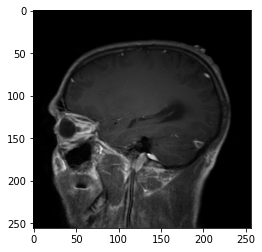


SOP Class........: 1.2.840.10008.5.1.4.1.1.7 (Secondary Capture Image Storage)

Patient's Name...: 
Patient ID.......: 
Modality.........: OT
Study Date.......: 20220328
Image size.......: 256 x 256
Pixel Spacing....: [0.9375, 0.9375]
Slice location...: (missing)



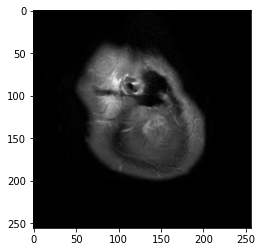


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: Deleted, 
Patient ID.......: debug
Modality.........: MR
Study Date.......: 20220215
Image size.......: 192 x 150
Pixel Spacing....: [1.19791662693024, 1.20000004768372]
Slice location...: (missing)



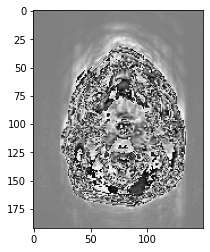


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: None
Modality.........: MR
Study Date.......: 20210721
Image size.......: 256 x 256
Pixel Spacing....: [0.7813, 0.7813]
Slice location...: -85.5



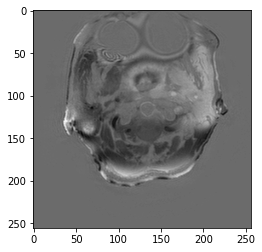

2022-07-07 09:58:18,239 WARNING Cannot decode image data with TransferSyntax: None



SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: TCGA-76-6661, 
Patient ID.......: TCGA-76-6661
Modality.........: MR
Study Date.......: 20011208
Image size.......: 256 x 256
Pixel Spacing....: [0.9375, 0.9375]
Slice location...: 37.4999997830618

SOP Class........: 1.2.840.10008.5.1.4.1.1.20 (Nuclear Medicine Image Storage)

Patient's Name...: FE4BP109M-BI, 
Patient ID.......: 214621
Modality.........: NM
Study Date.......: 19390618
Image size.......: 256 x 256
Pixel Spacing....: [+1.250000e+00, +1.250000e+00]
Slice location...: (missing)



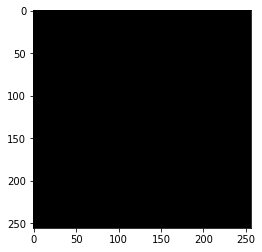


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 61504-04, 
Patient ID.......: 61504-04
Modality.........: MR
Study Date.......: 20210401
Image size.......: 328 x 240
Pixel Spacing....: [0.699971, 0.699971]
Slice location...: 34.011909



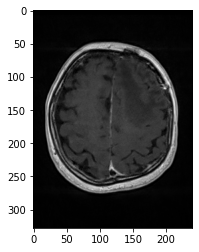


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 61504-04, 
Patient ID.......: 61504-04
Modality.........: MR
Study Date.......: 20210401
Image size.......: 328 x 240
Pixel Spacing....: [0.699971, 0.699971]
Slice location...: 34.011909



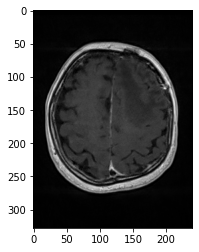


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 002_S_5230, 
Patient ID.......: 002_S_5230
Modality.........: MR
Study Date.......: 20191024
Image size.......: 256 x 240
Pixel Spacing....: [1, 1]
Slice location...: -51.909117460251



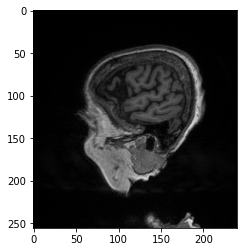


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 002_S_5230, 
Patient ID.......: 002_S_5230
Modality.........: MR
Study Date.......: 20220330
Image size.......: 256 x 240
Pixel Spacing....: [1, 1]
Slice location...: (missing)



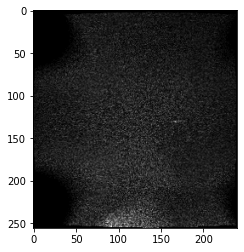


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 002_S_5230, 
Patient ID.......: 002_S_5230
Modality.........: MR
Study Date.......: 20220330
Image size.......: 256 x 240
Pixel Spacing....: [1, 1]
Slice location...: (missing)



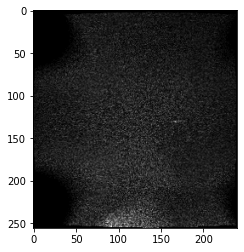


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 002_S_5230, 
Patient ID.......: 002_S_5230
Modality.........: MR
Study Date.......: 20220330
Image size.......: 256 x 240
Pixel Spacing....: [1, 1]
Slice location...: (missing)



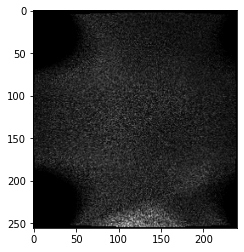


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 002_S_5230, 
Patient ID.......: 002_S_5230
Modality.........: MR
Study Date.......: 20220330
Image size.......: 256 x 240
Pixel Spacing....: [1, 1]
Slice location...: (missing)



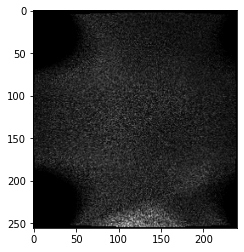


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 002_S_5230, 
Patient ID.......: 002_S_5230
Modality.........: MR
Study Date.......: 20220330
Image size.......: 256 x 240
Pixel Spacing....: [1, 1]
Slice location...: (missing)



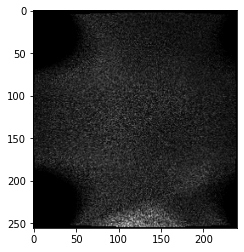


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 002_S_5230, 
Patient ID.......: 002_S_5230
Modality.........: MR
Study Date.......: 20151201
Image size.......: 256 x 256
Pixel Spacing....: [1, 1]
Slice location...: 153.600593566894



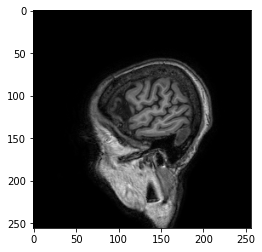


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 002_S_5230, 
Patient ID.......: 002_S_5230
Modality.........: MR
Study Date.......: 20220330
Image size.......: 256 x 256
Pixel Spacing....: [1, 1]
Slice location...: (missing)



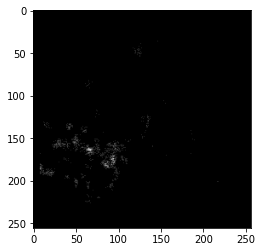


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 002_S_5230, 
Patient ID.......: 002_S_5230
Modality.........: MR
Study Date.......: 20151201
Image size.......: 256 x 256
Pixel Spacing....: [1.0546875, 1.0546875]
Slice location...: 76.8003005981445



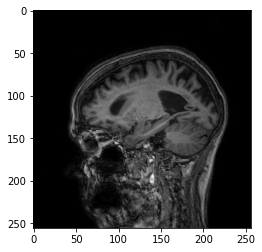


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 002_S_5230, 
Patient ID.......: 002_S_5230
Modality.........: MR
Study Date.......: 20220330
Image size.......: 256 x 256
Pixel Spacing....: [1.0546875, 1.0546875]
Slice location...: (missing)



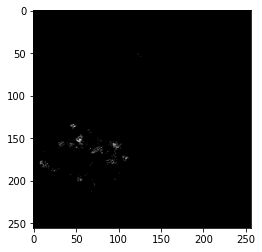


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 002_S_5230, 
Patient ID.......: 002_S_5230
Modality.........: MR
Study Date.......: 20220330
Image size.......: 256 x 256
Pixel Spacing....: [1.0546875, 1.0546875]
Slice location...: (missing)



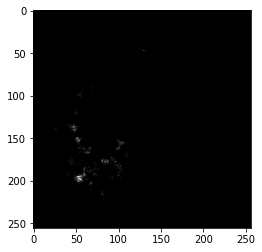


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 20181023, 
Patient ID.......: 20181023
Modality.........: MR
Study Date.......: 20181023
Image size.......: 192 x 192
Pixel Spacing....: [1.19791662693023, 1.19791662693023]
Slice location...: 91.2000512728050



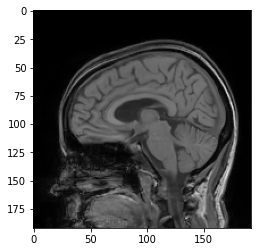

2022-07-07 09:58:19,534 WARNING Cannot decode image data with TransferSyntax: None



SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: Deleted, 
Patient ID.......: F8555BA8865A1
Modality.........: MR
Study Date.......: 20170919
Image size.......: 256 x 256
Pixel Spacing....: [1.0156, 1.0156]
Slice location...: -70.6262588501

SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 128 x 128
Pixel Spacing....: [1.0703125, 1.0703125]
Slice location...: -50.899095150944



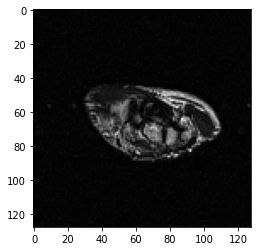


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 128 x 128
Pixel Spacing....: [1.0703125, 1.0703125]
Slice location...: -50.899095150944



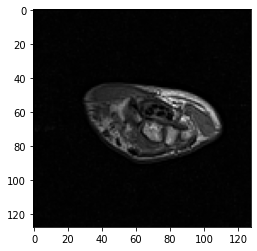


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 256 x 256
Pixel Spacing....: [0.53515625, 0.53515625]
Slice location...: -50.899095150944



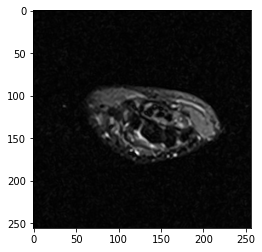


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 128 x 96
Pixel Spacing....: [1.2578125, 1.2578125]
Slice location...: 46.88445977971



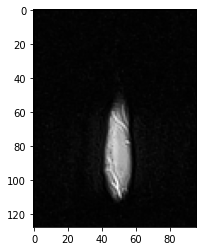


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 128 x 96
Pixel Spacing....: [1.2578125, 1.2578125]
Slice location...: 46.88445977971



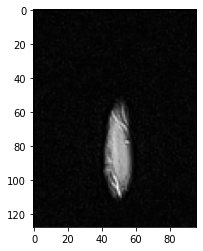


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 192 x 192
Pixel Spacing....: [0.72916668653488, 0.72916668653488]
Slice location...: -34.476282863864



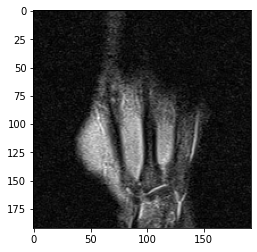


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 192 x 192
Pixel Spacing....: [0.72916668653488, 0.72916668653488]
Slice location...: -37.776283662917



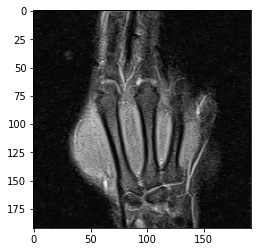


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 128 x 128
Pixel Spacing....: [1.09375, 1.09375]
Slice location...: -37.776283700705



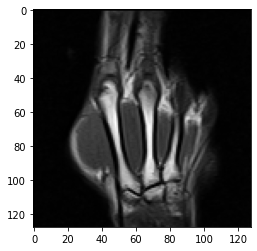


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 192 x 192
Pixel Spacing....: [0.72916668653488, 0.72916668653488]
Slice location...: -37.776283662917



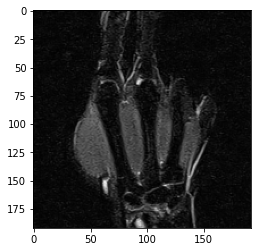


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 128 x 128
Pixel Spacing....: [1.09375, 1.09375]
Slice location...: -64.176282595135



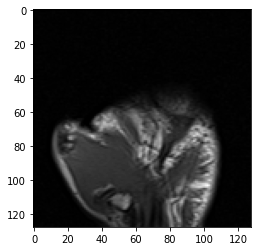


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 192 x 192
Pixel Spacing....: [0.72916668653488, 0.72916668653488]
Slice location...: -34.476282863864



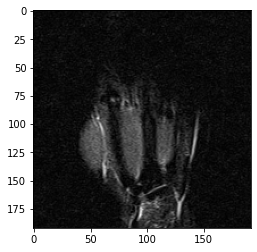


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 128 x 128
Pixel Spacing....: [1.0703125, 1.0703125]
Slice location...: 15.100904007585



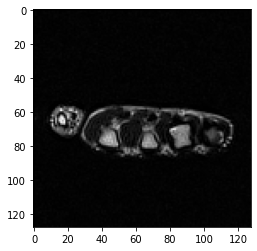


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 128 x 128
Pixel Spacing....: [1.0703125, 1.0703125]
Slice location...: -21.199096965545



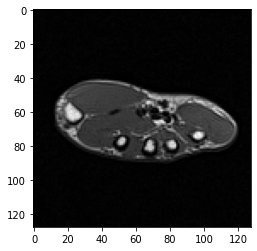


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 256 x 256
Pixel Spacing....: [0.53515625, 0.53515625]
Slice location...: 31.600903659474



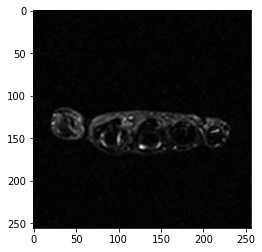


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 128 x 96
Pixel Spacing....: [1.2578125, 1.2578125]
Slice location...: 3.6844601108993



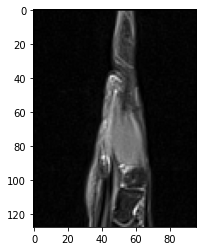


SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: 
Patient ID.......: 19086541
Modality.........: MR
Study Date.......: 20211221
Image size.......: 128 x 96
Pixel Spacing....: [1.2578125, 1.2578125]
Slice location...: 18.084460642264



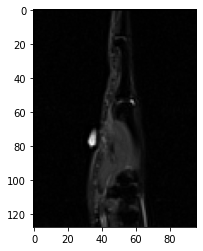

In [34]:
show_dcm_info(dcm_list)

***

# Read DICOM images of a specific Subject


## Helpful Function

In [35]:
def read_all_dcm_from_archive(file_entry, acq):
    """
    For a given file entry, read a dicom file from the archive.
    Method here will read the dicom file from the archive as raw data and read that raw data into pydicom.
    It will return a list of pydicom objects for the Subject.
    """
    
    import pydicom
    from pydicom.filebase import DicomBytesIO
    
    subj_dcm = list()
    
    # Check that this file is valid
    if file_entry['type'] != 'dicom':
        raise TypeError('Must be a DICOM file')
        
    log.info(f'Loading {file_entry["name"]}')
    
    # Using the `get_file_zip_info` method to retrieve the files information within the zip file.
    zip_info = acq.get_file_zip_info(file_entry['name'])
    
    for i, member in enumerate(zip_info.members):
        if member.size == 0:
            continue
        raw_dcm = DicomBytesIO(acq.read_file_zip_member(file_entry['name'], member.path))
        dcm = pydicom.dcmread(raw_dcm, force=True)
        if 'SOPClassUID' in dcm:
            subj_dcm.append(dcm)

    log.info(f'Processed {len(subj_dcm)} DICOM files.')
    
    return subj_dcm
    

Let's say you are only interested in a specific Subject and you would like to do some analysis with the Subject's DICOM image.

Get the `anx_s4` Subject container

In [41]:
subj_04 = project.subjects.find_first('label=dicom-fixer')

Get the DICOM zip archive for the Subject `anx_s4`.

In [42]:
for sess in subj_04.sessions():
    for acq in sess.acquisitions():
        for files in acq['files']:
            if files['type'] == 'dicom':
                subj_dcm = read_all_dcm_from_archive(files,acq)

2022-07-07 09:59:39,602 INFO Loading 23492_7_1.dicom.zip
2022-07-07 10:02:20,534 INFO Processed 600 DICOM files.
2022-07-07 10:02:20,555 INFO Loading 1501 - T1 SAG SE.dicom
2022-07-07 10:02:20,833 INFO Processed 1 DICOM files.


Helpful function that get the zip file member and store all the zip member dicom file for one subject.

In [43]:
show_dcm_info(subj_dcm)

2022-07-07 10:02:26,308 WARNING Cannot decode image data with TransferSyntax: None



SOP Class........: 1.2.840.10008.5.1.4.1.1.4 (MR Image Storage)

Patient's Name...: TCGA-76-6661, 
Patient ID.......: TCGA-76-6661
Modality.........: MR
Study Date.......: 20011208
Image size.......: 256 x 256
Pixel Spacing....: [0.9375, 0.9375]
Slice location...: 37.4999997830618


## Interactive DICOM viewer 

We will be using the `ipywidgets.interactive()` method to build a DICOM Viewer from the DICOM image that we have pulled from the Subject.

In [44]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [45]:
# slide through dicom images using a slide bar 
plt.figure(10)
def dicom_animation(x):
    plt.imshow(subj_dcm[x].pixel_array, cmap=plt.cm.gray)
    
interact(dicom_animation, x=(0, len(subj_dcm)-1))

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=0, description='x', max=0), Output()), _dom_classes=('widget-interact',)…

<function __main__.dicom_animation(x)>

***

# Download a Zip member from a Zip Archive in Analysis container via SDK

Often a gear will store its output into a large zip file in an analysis container and it can be useful to extract specific file from it across different gear runs. In this section, you will learn how to get a zip file member from Flywheel and download the files into your local directory

## Get analyses container

First, we get the Subject container first. In this tutorial we will be working with `sub-04`.

In [ ]:
subj = project.subjects.find_first('label=sub-04')

We will be working with the first Session for Subject `sub-4` and the first Analyses in the Session container.

In [ ]:
session_container = subj.sessions()[0]

In [ ]:
analysis = session_container.reload()['analyses'][0]

<div class="alert alert-block alert-info" style="color:black"><b>Info:</b> Use <code>reload()</code> method here to retrieve a complete view of the data within the Session container .</div>

Now, we will loop through the files within the analyses container in the Session container.

In [ ]:
for file in analysis['files']:
    print(file.name)

After looking at the available files in the Analysis container, we decided to work with the second file in the Analysis container.

In [74]:
zip_file_name = analysis['files'][1].name

In [ ]:
analysis_id = analysis.id
analysis_id

To retrieve the files information within the zip file, you can use `get_file_zip_info` which will take the `zip_file_name` as argument. 

In [ ]:
zip_info = analysis.get_file_zip_info(zip_file_name)

In [ ]:
len(zip_info.members)

Let's see what the archive contains and pinpoint the location of the `.nifti` file.

In [ ]:
for ii, file in enumerate(zip_info.members):
    if file.path[-1] != '/':
        if file.path.endswith('nii.gz'):
            print(f'{ii} {Path(file.path).name}')
    else:
        print(f'dir {file.path}')

## Download File

To download the file from the zip output file, we will be using `download_file_zip_member` method. It requires three parameters, which is `file_name`: The name of the zip file, `member_path`: the choosen member in the zip file, and `dest_file`: The name of the file you would like to download as.

In this example, we are going to download the 86th member in the zip file and save as `vectorRGB.nii.gz` on your local directory.

In [ ]:
member_path = zip_info.members[86].path
dest_file = Path(zip_info.members[86].path).name

analysis.download_file_zip_member(zip_file_name, member_path, dest_file)